<a href="https://colab.research.google.com/github/MOTURUPRAVEENBHARGAV/-Classification-models-on-purchase_prediction-Data/blob/master/Copy_of_BERT_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Transformers
Installing the Transformers library is fairly easy. Just run the following pip line on a Google Colab cell:


In [ ]:
pip install transformers

     |████████████████████████████████| 1.9MB 5.1MB/s 
     |████████████████████████████████| 3.2MB 5.4MB/s 
     |████████████████████████████████| 890kB 7.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=950f51d642751be18338fc057117cd1d71083cf2daabd0ca09785ff90a5d9640
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


After the installation is completed, we will load the pre-trained BERT Tokenizer and Sequence Classifier as well as InputExample and InputFeatures. Then, we will build our model with the Sequence Classifier and our tokenizer with BERT’s Tokenizer.

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let’s see the summary of our BERT model:

Here are the results. We have the main BERT model, a dropout layer to prevent overfitting, and finally a dense layer for classification task:

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


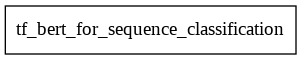

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

Now that we have our model, let’s create our input sequences from the IMDB reviews dataset:

IMDB Dataset

IMDB Reviews Dataset is a large movie review dataset collected and prepared by Andrew L. Maas from the popular movie rating service, IMDB. The IMDB Reviews dataset is used for binary sentiment classification, whether a review is positive or negative. It contains 25,000 movie reviews for training and 25,000 for testing. All these 50,000 reviews are labeled data that may be used for supervised deep learning. Besides, there is an additional 50,000 unlabeled reviews that we will not use in this case study. In this case study, we will only use the training dataset.

Initial Imports

We will first have two imports: TensorFlow and Pandas.

In [ ]:
import tensorflow as tf
import pandas as pd

Get the Data from the Stanford Repo

Then, we can download the dataset from Stanford’s relevant directory with *tf.keras.utils.get_file* function, as shown below:

In [ ]:
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

84131840/84125825 [==============================] - 9s 0us/step


In [ ]:

# The shutil module offers a number of high-level 
# operations on files and collections of files.
import os
import shutil
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['neg', 'urls_unsup.txt', 'urls_pos.txt', 'pos', 'labeledBow.feat', 'urls_neg.txt', 'unsupBow.feat']


## **Train and Test Split**

Now that we have our data cleaned and prepared, we can create *text_dataset_from_directory* with the following lines. I want to process the entire data in a single batch. That’s why I selected a very large batch size:

In [ ]:

# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


## Convert to Pandas to View and Process

Now we have our basic train and test datasets, I want to prepare them for our BERT model. To make it more comprehensible, I will create a pandas dataframe from our TensorFlow dataset object. The following code converts our train Dataset object to train pandas dataframe:

In [ ]:
for i in train.take(1):
  print(i)
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

(<tf.Tensor: shape=(20000,), dtype=string, numpy=
array([b"Canadian director Vincenzo Natali took the art-house circuit by storm with the intriguing and astonishingly intelligent Cube, which is my personal favourite SF film of the 90s. It framed the basic conceit of a group of strangers trapped in a maze shaped like a giant cube, shot entirely on one set, and took this idea in fascinating directions. <br /><br />I've been eagerly awaiting Natali's follow-up, and although its taken five years for him to mount another project, I'm delighted to say it was worth the wait. Cypher is a fascinating exploration of one man's place in the world, and how through a completely logical chain of events, finds himself in a situation beyond his control.<br /><br />I don't want to reveal too much about the plot, because one of the joys of Cypher is the different avenues it takes us down. It is so refreshing in this day and age to see a SF film that has more than one idea in it's head. Cypher is such a f

In [ ]:
train_feat

array([b"Canadian director Vincenzo Natali took the art-house circuit by storm with the intriguing and astonishingly intelligent Cube, which is my personal favourite SF film of the 90s. It framed the basic conceit of a group of strangers trapped in a maze shaped like a giant cube, shot entirely on one set, and took this idea in fascinating directions. <br /><br />I've been eagerly awaiting Natali's follow-up, and although its taken five years for him to mount another project, I'm delighted to say it was worth the wait. Cypher is a fascinating exploration of one man's place in the world, and how through a completely logical chain of events, finds himself in a situation beyond his control.<br /><br />I don't want to reveal too much about the plot, because one of the joys of Cypher is the different avenues it takes us down. It is so refreshing in this day and age to see a SF film that has more than one idea in it's head. Cypher is such a film.<br /><br />Morgan Sullivan (Jeremy Northam), 

In [ ]:
train_lab

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

In [ ]:
train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


I will do the same operations for the test dataset with the following lines:

In [ ]:
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


## Creating Input Sequences

We have two pandas Dataframe objects waiting for us to convert them into suitable objects for the BERT model. We will take advantage of the InputExample function that helps us to create sequences from our dataset. The *InputExample* function can be called as follows:

In [ ]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

## Now we will create two main functions:

- 1 — convert_data_to_examples: This will accept our train and test datasets and convert each row into an InputExample object.

- 2 — convert_examples_to_tf_dataset: This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model.

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

## We can call the functions we created above with the following lines:

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Our dataset containing processed input sequences are ready to be fed to the model.

### Configuring the BERT model and Fine-tuning

We will use Adam as our optimizer, CategoricalCrossentropy as our loss function, and SparseCategoricalAccuracy as our accuracy metric. Fine-tuning the model for 2 epochs will give us around 95% accuracy, which is great.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

Training the model might take a while, so ensure you enabled the GPU acceleration from the Notebook Settings. After our training is completed, we can move onto making sentiment predictions.

In [ ]:
model.save("BERT_With_TF.h5")  #---- This .h5 doesn't work to save the subclassed model its because of not sequential model.


NotImplementedError: ignored

In [ ]:
# from tensorflow.keras.models import load_model
# # my_model=load_model()
# # my_model = tf.saved_model.load("/content/Bert model/saved_model.pb")

# import tensorflow as tf
# converter = tf.lite.TFLiteConverter.from_keras_model("/content/Bert model/saved_model.pb")
# tflite_model = converter.convert()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/BERT_Model', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/BERT_Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/BERT_Model/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Making Predictions

I created a list of two reviews I created. The first one is a positive review, while the second one is clearly negative.

In [ ]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']


In [ ]:
type(test)

list

We need to tokenize our reviews with our pre-trained BERT tokenizer. We will then feed these tokenized sequences to our model and run a final softmax layer to get the predictions. We can then use the *argmax* function to determine whether our sentiment prediction for the review is positive or negative. Finally, we will print out the results with a simple for loop. The following lines do all of these said operations:

In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_outputs

TFSequenceClassifierOutput([('logits',
                             <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
                             array([[-3.907434 ,  3.241432 ],
                                    [ 3.935399 , -3.3383203]], dtype=float32)>)])

In [ ]:
print(tf_outputs[0])

tf.Tensor(
[[-3.907434   3.241432 ]
 [ 3.935399  -3.3383203]], shape=(2, 2), dtype=float32)


In [ ]:

tf_predictions = tf.nn.softmax(tf_outputs[0], axis=1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=-1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good : 
 Positive
One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie : 
 Negative


In [ ]:
d=test["DATA_COLUMN"].astype(str)

In [ ]:
d.shape

(5000,)

In [ ]:
l=[]
for i in d:
  l.append(i)

In [ ]:
test1=l[0:820]
tf_batch1 = tokenizer(test1, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs1 = model(tf_batch1)
tf_predictions1 = tf.nn.softmax(tf_outputs1[0], axis=-1)
labels = ['Negative','Positive']
label1 = tf.argmax(tf_predictions1, axis=1)
label1 = label1.numpy()
# for i in range(len(test1)):
#   print(test[i], ": \n", labels[label1[i]])

ResourceExhaustedError: ignored

# OOM when allocating tensor with shape[820,128,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:AddV2]


# ERROR : OUT OF MEMORY 

## So thats why only 810 records are testified

In [ ]:
df1=label1
df1.shape

(810,)

In [ ]:
import numpy as np
y_test= test["LABEL_COLUMN"].iloc[0:810]
y_pred=df1

In [ ]:
y_test1=list(y_test.astype(int))
y_pred1=list(y_pred)
print(y_pred1)

[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
cm=confusion_matrix(y_test1,y_pred1)
cm

array([[322,  68],
       [ 28, 392]])

In [ ]:
from sklearn.metrics import accuracy_score
print(f"BERT MODEL- Accuracy_Score: {accuracy_score(y_test1,y_pred1)}")

BERT MODEL- Accuracy_Score: 0.8814814814814815


In [ ]:
print(classification_report(y_test1,y_pred1,target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.92      0.83      0.87       390
    Positive       0.85      0.93      0.89       420

    accuracy                           0.88       810
   macro avg       0.89      0.88      0.88       810
weighted avg       0.88      0.88      0.88       810



In [ ]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='BERT_TF Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="right",
                 color="White" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


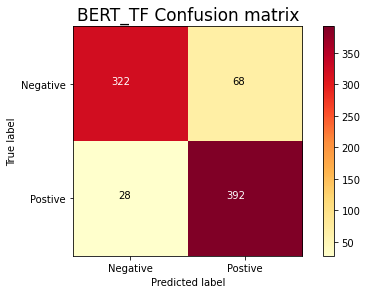

In [ ]:
import itertools
plot_confusion_matrix(cm,["Negative","Postive"])
plt.show()